In [1]:
import psycopg2
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import random
import plotly.express as px
from datetime import timedelta, datetime, tzinfo, timezone,  time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

-----------------------------------------------------

In [2]:
general_path = 'E:/paper2_analysis/traffic_analysis/Omnitrans_denHelder'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

----------------------

#### create results dataframe

In [3]:
# ## ONLY TO CREATE NEW ONE

# results_df_ini  = pd.DataFrame(columns = {
#                             '_sim_code','result','scen','depth_thr', 'time_thr', 
#                             'hh_evaqzone', 'cleartime', 
#                             'left_zone_hh', 'left_zone_p', 
#                             'stuck_network_hh', 'stuck_network_p', 
#                             'safe_hh', 'safe_p'})


# #add first dummy
# ini_sim = pd.DataFrame(['aa'],columns=['_sim_code'])
# results_df_ini = pd.concat([results_df_ini,ini_sim])

# results_df_ini.to_json(f'{output_path}/results_overview/overview_results.json')


------------------

### read file

In [4]:
results_df = pd.read_json(f'{output_path}/results_overview/overview_results.json')
results_df


,_sim_code,scen,result,hh_evaqzone,depth_thr,time_thr,cleartime,safe_hh,safe_p,left_zone_hh,left_zone_p,stuck_network_hh,stuck_network_p
0,aa,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f1_d1.5_a30_r60,scen1_voorpiek,60.0,22045.0,1.5,30.0,NaN,11607.0,53.0,5503.0,25.0,4935.0,22.0
2,f1_d2.0_a30_r61,scen1_voorpiek,61.0,22040.0,2.0,30.0,NaN,11846.0,54.0,4999.0,23.0,5195.0,24.0
3,f1_d2.5_a30_r62,scen1_voorpiek,62.0,15610.0,2.5,30.0,NaN,11609.0,74.0,2366.0,15.0,1635.0,10.0
4,f1_d1.5_a60_r63,scen1_voorpiek,63.0,11600.0,1.5,60.0,12.50,11600.0,100.0,0.0,0.0,0.0,0.0
5,f1_d2.0_a60_r64,scen1_voorpiek,64.0,11595.0,2.0,60.0,12.25,11595.0,100.0,0.0,0.0,0.0,0.0
6,f1_d2.5_a60_r65,scen1_voorpiek,65.0,7430.0,2.5,60.0,5.17,7430.0,100.0,0.0,0.0,0.0,0.0
7,f1_d2.7_a30_r66,scen1_voorpiek,66.0,10965.0,2.7,30.0,29.67,10947.0,100.0,0.0,0.0,18.0,0.0
8,f1_d2.5_a45_r67,scen1_voorpiek,67.0,9205.0,2.5,45.0,6.33,9205.0,100.0,0.0,0.0,0.0,0.0
9,f2_d1.5_a30_r70,scen2_napiek,70.0,10045.0,1.5,30.0,6.92,10045.0,100.0,0.0,0.0,0.0,0.0


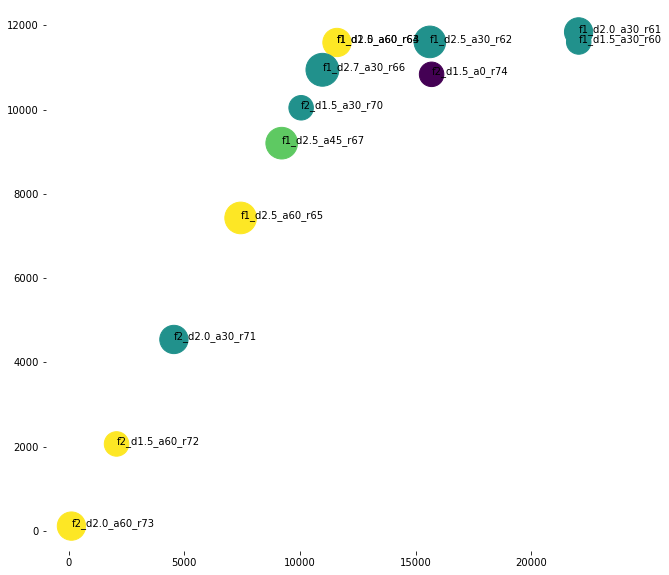

In [6]:
fig = plt.figure(figsize=(10, 10),frameon=False)
ax = fig.add_subplot(1, 1, 1, frameon=False)
# ax.set_facecolor('#e9ecef')

labels = results_df._sim_code

ax.scatter(results_df.hh_evaqzone, results_df.safe_hh, s = results_df.depth_thr*400, c = results_df.time_thr )

for i, label in enumerate(labels):
    ax.annotate(label, (results_df.hh_evaqzone[i], results_df.safe_hh[i]))


plt.savefig(f'{figures_path}/ALL/overview.png')
                                                


---------------------------

### add simulation codes

In [72]:
def add_new_sim(new_sim_id, results_df):
    if new_sim_id not in results_df._sim_code.values:
        print(f'{new_sim_id} added')
        new_sim = pd.DataFrame([new_sim_id],columns=['_sim_code'])
        results_df = pd.concat([results_df,new_sim], ignore_index=True)
        results_df.to_json(f'{output_path}/results_overview/overview_results.json')  
    else:
        print(f'{new_sim_id} is allready in list')
    return results_df

In [73]:
currents_sims = ['f1_d1.5_a30_r60', 
                 'f1_d2.0_a30_r61', 
                 'f1_d2.5_a30_r62', 
                 'f1_d1.5_a60_r63', 
                 'f1_d2.0_a60_r64', 
                 'f1_d2.5_a60_r65', 
                 'f1_d2.7_a30_r66', 
                 'f1_d2.5_a45_r67', 
                 'f2_d1.5_a30_r70', 
                 'f2_d2.0_a30_r71', 
                 'f2_d1.5_a60_r72', 
                 'f2_d2.0_a60_r73', 
                 'f2_d1.5_a0_r74', 
                 'f2_d1_a30_r75']


In [74]:
for i in currents_sims:
    results_df = add_new_sim(i, results_df)

f1_d1.5_a30_r60 added
f1_d2.0_a30_r61 added
f1_d2.5_a30_r62 added
f1_d1.5_a60_r63 added
f1_d2.0_a60_r64 added
f1_d2.5_a60_r65 added
f1_d2.7_a30_r66 added
f1_d2.5_a45_r67 added
f2_d1.5_a30_r70 added
f2_d2.0_a30_r71 added
f2_d1.5_a60_r72 added
f2_d2.0_a60_r73 added
f2_d1.5_a0_r74 added
f2_d1_a30_r75 added


In [77]:
results_df.head(5)


,_sim_code,stuck_network_p,safe_p,depth_thr,left_zone_hh,time_thr,stuck_network_hh,scen,cleartime,hh_evaqzone,left_zone_p,result,safe_hh
0,aa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f1_d1.5_a30_r60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f1_d2.0_a30_r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f1_d2.5_a30_r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f1_d1.5_a60_r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
results_df

,_sim_code,stuck_network_p,safe_p,depth_thr,left_zone_hh,time_thr,stuck_network_hh,scen,cleartime,hh_evaqzone,left_zone_p,result,safe_hh
0,aa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f1_d1.5_a30_r60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f1_d2.0_a30_r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f1_d2.5_a30_r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f1_d1.5_a60_r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,f1_d2.0_a60_r64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,f1_d2.5_a60_r65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,f1_d2.7_a30_r66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,f1_d2.5_a45_r67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,f2_d1.5_a30_r70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
